# Patient RAO

**Author:** Ximena Fernandez

In this notebook we present the analysis of the time series derived from MEG recordings, using methods from TDA.

### The data

The dataset is the MEG recording of the brain activity for 171 channels (regions) of the patient RAO (Toronto Western Hospital).

In [5]:
from scipy.io import loadmat

data = loadmat('data/Data_RAO_MEG_SZ_15.mat')['MdataSz']

In [6]:
N, T = data.shape

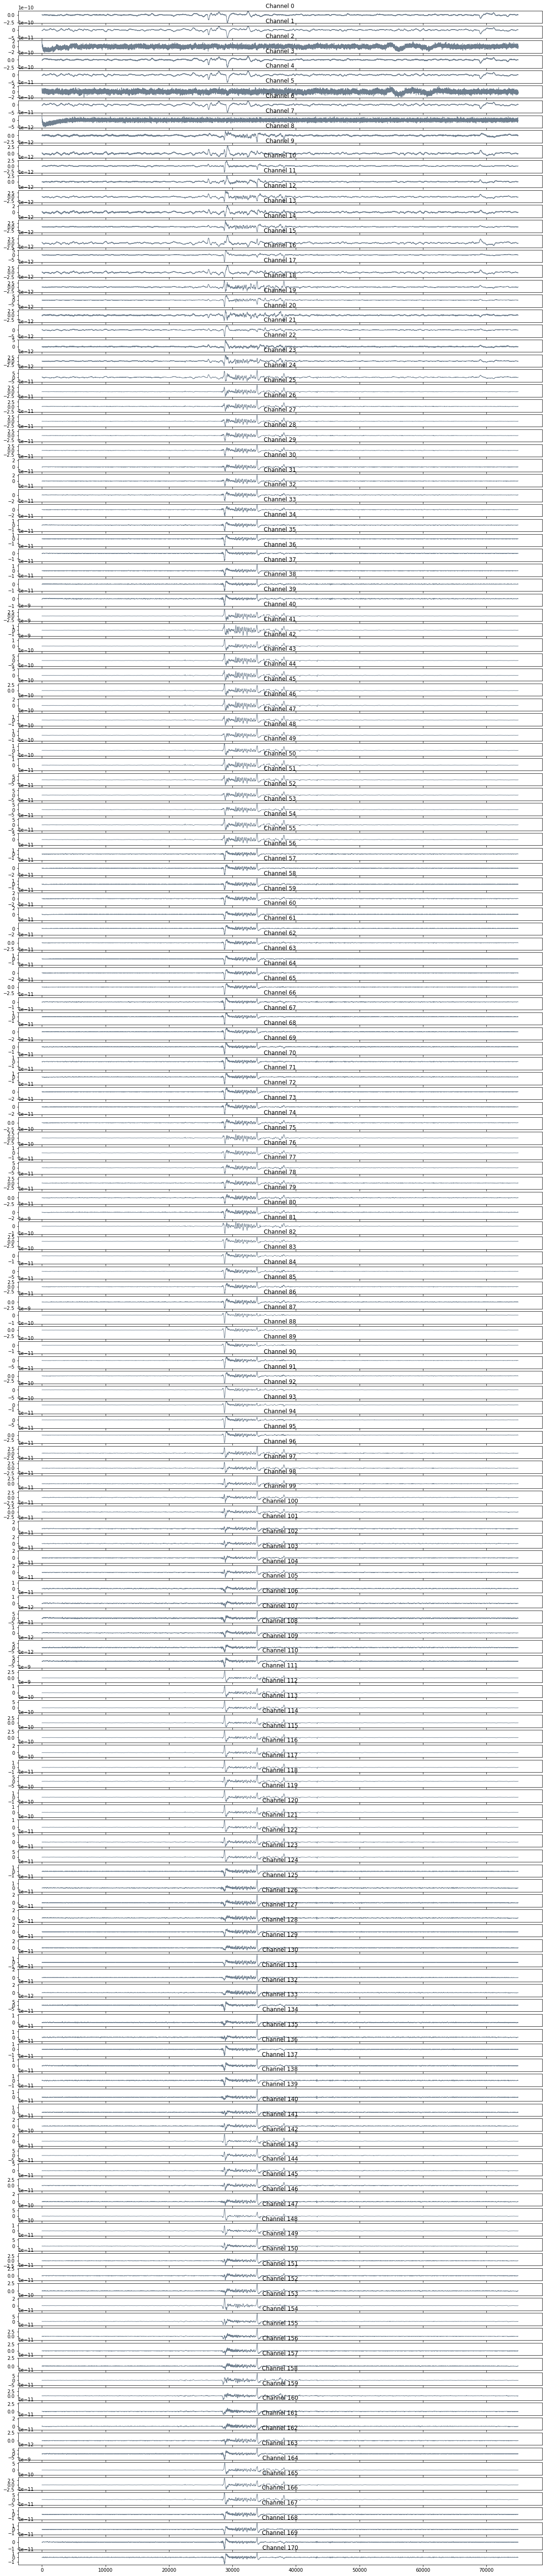

In [5]:
fig = plt.figure(figsize=(20, 100))
for i in range(0,N):
    s = data[i]
    ax = fig.add_subplot(N,1,i+1)
    plt.plot(range(0, len(s)), s[0:], lw= 1, color = 'slategrey')
    #plt.axis('off')
    ax.set_title('Channel %s'%i)

### Sliding Window Embedding

We compute the joint embedding of the signals $X_1, X_2, \dots X_N$ in the Euclidean space, to obtain a point cloud in $\mathbb {R}^N$
$$
\left\{(X_1(t), X_2(t), \dots X_N(t))\colon t \in [0,T]\right\}
$$


The **evolution** of the topology of the embedding can be captured by means of the persistent homology of the sliding window embedding, with $t$ running along all the interval $[W, T]$.

In [9]:
from ripser import Rips
import numpy as np

rips = Rips()
window_persistence_diagrams = {}
window_persistence_diagrams[0] = {}
window_persistence_diagrams[1] = {}
step = 100
window_size = 1000
for t in np.arange(window_size, int(75000), step):
    diagram = rips.fit_transform(data.T[t-window_size:t, :])
    window_persistence_diagrams[0][t] = diagram[0]
    window_persistence_diagrams[1][t] = diagram[1]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


### Consecutive Wasserstein distance
In order to quantify the local changes in the topology of the embedding along the time interval, we compute the **Wasserstein distance** between the consecutive persistent diagrams in a sample $t_1, t_2, \dots, t_n\in [W, T]$:

$$
\dfrac{d_W\Big(\mathrm{dgm}\big(X_W(t_i)\big), \mathrm{dgm}\big(X_W(t_{i+1})\big)\Big)}{|t_i-t_{i+1}|}
$$
This is an estimator of the first derivative of $\mathrm{dgm}(X_W(t))$.

In [11]:
import warnings
warnings.filterwarnings("ignore")
import persim

w_wasserstein = {}
for i in range(2):
    w_wasserstein[i] = {}
for i in range(2):
    for t in list(window_persistence_diagrams[0].keys())[1:]:
        w_wasserstein[i][t] = persim.wasserstein(window_persistence_diagrams[i][t], window_persistence_diagrams[i][t-step])

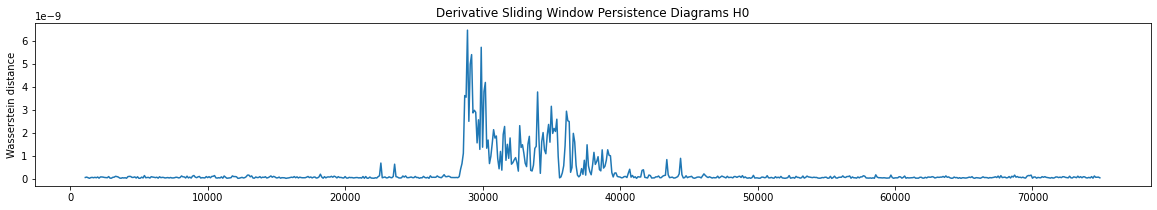

In [16]:
fig = plt.figure(figsize=(20,3))

plt.plot(list(window_persistence_diagrams[0].keys())[1:], w_wasserstein[0].values());
plt.ylabel('Wasserstein distance')
plt.title('Derivative Sliding Window Persistence Diagrams H0')
plt.savefig('figures/SW_RAO_consecutive_distance_H0.png')

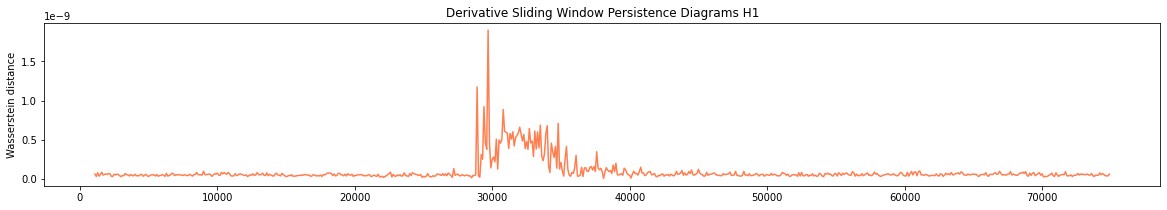

In [17]:
fig = plt.figure(figsize=(20,3))

plt.plot(list(window_persistence_diagrams[0].keys())[1:], w_wasserstein[1].values(), color = 'coral')
plt.ylabel('Wasserstein distance')
plt.title('Derivative Sliding Window Persistence Diagrams H1')
plt.savefig('figures/SW_RAO_consecutive_distance_H1.png')

### Persistence summary functions

In addition  we compute a series of summary functions associated to $\mathrm{dgm}(X_W(t))$ for every $t\in [W, T]$, to track the evolution of different features associated to the persistent diagrams.

  - **Total persistence**

$$||\mathcal{D}||_1 = \sum_{(x,y) \in \mathcal{D}} pers(x,y)$$

  - **Standard deviation persistence**

$$\sigma(\mathcal{D}) = \text{Standard Deviation}\{pers(x,y): (x,y) \in \mathcal{D}\} $$

In [ ]:
w_persistence = {}
w_std = {}
w_mean = {}
w_sum = {}
w_mean_death1 = {}

for i in range(2):
    w_persistence[i] = {}
    w_mean[i] = {}
    w_std[i] = {}  
    w_sum[i] = {}

for t in window_persistence_diagrams[0].keys():
    w_persistence[0][t] = np.sort(window_persistence_diagrams[0][t][:,1]-window_persistence_diagrams[0][t][:,0])[:-1]
    w_persistence[1][t] = np.sort(window_persistence_diagrams[1][t][:,1]-window_persistence_diagrams[1][t][:,0])
    w_mean_death1[t] = window_persistence_diagrams[1][t][:,1].mean()
    for i in range(2):
        w_mean[i][t] = w_persistence[i][t].mean()
        w_std[i][t] = w_persistence[i][t].std()
        w_sum[i][t] = w_persistence[i][t].sum()

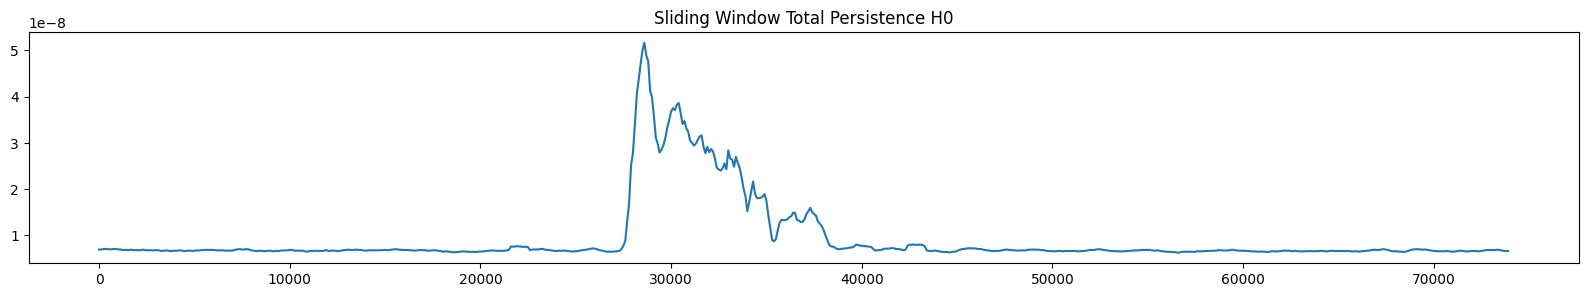

In [74]:
fig = plt.figure(figsize=(20,3))

plt.plot(window_persistence_diagrams[0].keys(), w_sum[0].values());
plt.title('Sliding Window Total Persistence H0');
plt.savefig('figures/SW_RAO_total_persistence_H0.png')

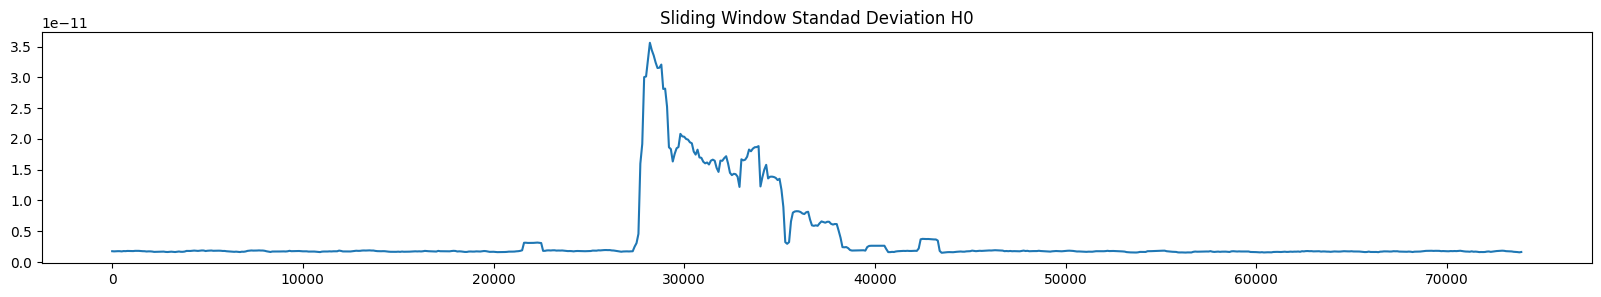

In [42]:
fig = plt.figure(figsize=(20,3))

plt.plot(window_persistence_diagrams[0].keys(), w_std[0].values());
plt.title('Sliding Window Standad Deviation H0');

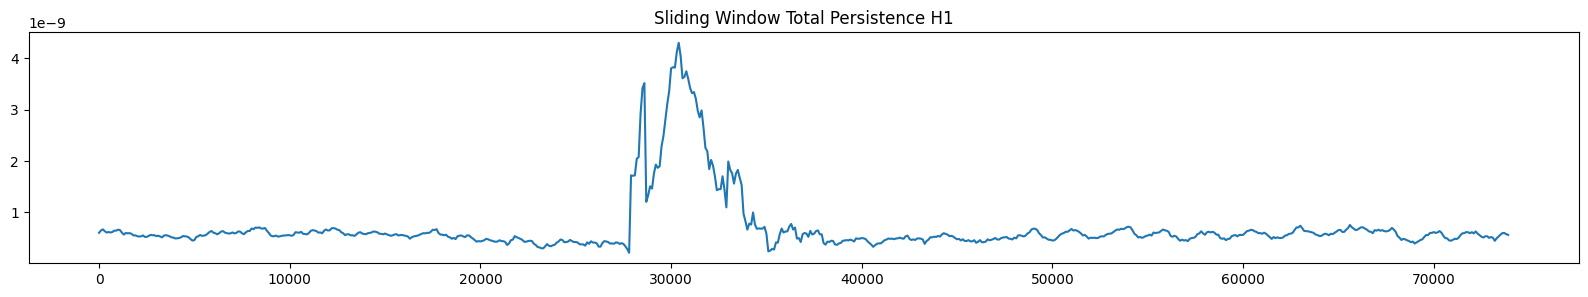

In [75]:
fig = plt.figure(figsize=(20,3))

plt.plot(window_persistence_diagrams[1].keys(), w_sum[1].values());
plt.title('Sliding Window Total Persistence H1');
plt.savefig('figures/SW_RAO_total_persistence_H1.png')

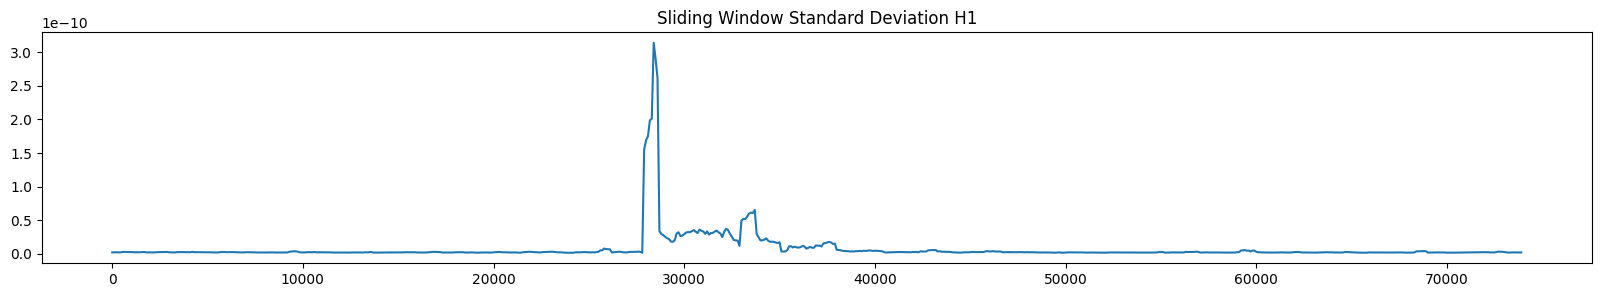

In [45]:
fig = plt.figure(figsize=(20,3))

plt.plot(window_persistence_diagrams[0].keys(), w_std[1].values());
plt.title('Sliding Window Standard Deviation H1');

  - **Persistent Entropy**
  
$$E(\mathcal{D}) = - \sum_{(x,y) \in \mathcal{D}} \frac{pers(x,y)}{L} \log\left(\frac{pers(x,y)}{L} \right)$$
where $L = \sum_{(x,y) \in \mathcal{D}}pers(x,y)$.

In [12]:
from gtda.diagrams import PersistenceEntropy
from gtda.homology import VietorisRipsPersistence
from scipy.spatial import distance_matrix

PE = PersistenceEntropy()
VR = VietorisRipsPersistence(homology_dimensions=[0, 1], metric = 'precomputed') 
entropy = {}
entropy[0] = {}
entropy[1] = {}


step = 100
window_size = 1000
for t in np.arange(window_size, int(75000), step):
    window = data.T[t-window_size:t, :]
    matrix = distance_matrix(window, window)
    diagram = VR.fit_transform(matrix[None, :,:])
    ent = PE.fit_transform(diagram)
    for i in range(2):
        entropy[i][t] = ent[0][i]

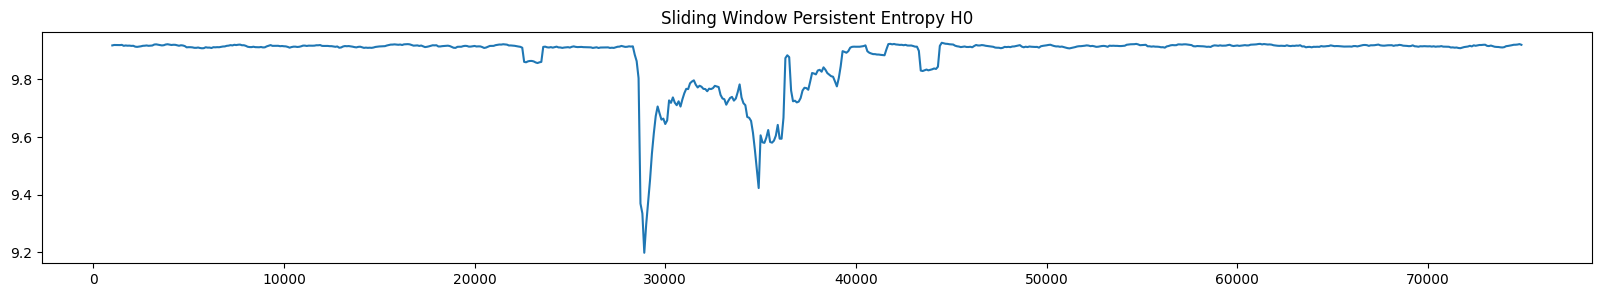

In [79]:
fig = plt.figure(figsize=(20,3))

plt.plot(entropy[0].keys(), entropy[0].values());
plt.title('Sliding Window Persistent Entropy H0');
plt.savefig('figures/SW_RAO_entropy_H0.png')

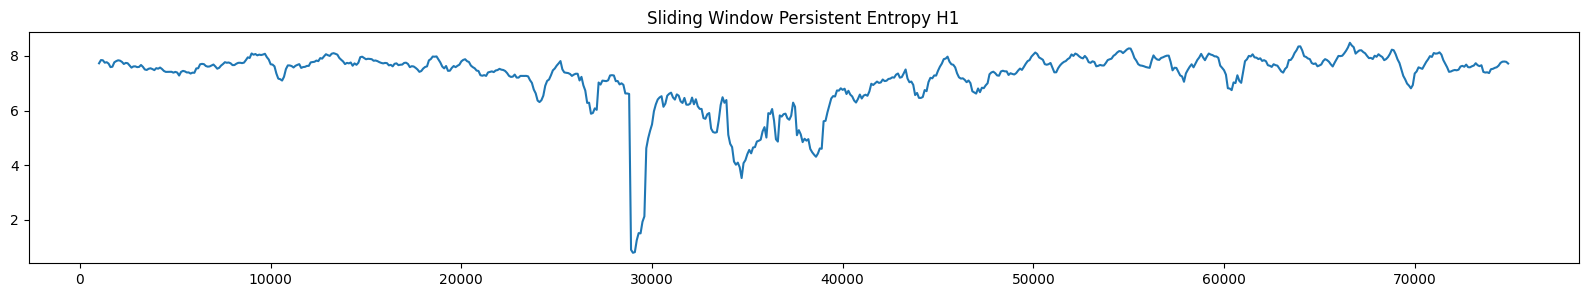

In [80]:
fig = plt.figure(figsize=(20,3))

plt.plot(entropy[1].keys(), entropy[1].values());
plt.title('Sliding Window Persistent Entropy H1');
plt.savefig('figures/SW_RAO_entropy_H1.png')